In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from utils import *
from preprocessing import load_data
from RandomFeats import define_rand_feats
from ClusterMLP import mlp_main

In [2]:
### CONFIG
task = 'potency'
n_comps = 32 # Num pca components
p = 0.3 # Upper pth percentile for subsets
c = 24 # Num clusters
solver = False # Solver for LogisticRegression (True - liblin, slower but better)
N = 64 # Num betas to fit (Typically 512 or 1280)
M = 500 # Num betas to generate for inference (Typically 25k-100k)

In [3]:
data = load_data(task, n_comps)

In [4]:
np.random.seed(74)
X, Y = data['train']
K = X.shape[-1]
r = K * 5
model = define_rand_feats(X, r)

In [5]:
kmeans = KMeans(n_clusters=c, random_state=0)
labels = kmeans.fit_predict(X)

In [6]:
# Generate random k-dimensional binary vectors
p = 0.3 # Independent Bernoulli Probability of each cluster
cluster_vectors = np.random.binomial(1, p, size=(N, c))  # N random subsets
# Ensure at least one cluster is included
for clust in cluster_vectors:
    if np.sum(clust) == 0:
        random_index = np.random.randint(k)  # choose a random index
        clust[random_index] = 1  # set this bit to 1

In [7]:
betas = []
accs = []
i = 0
print(f"Starting {len(cluster_vectors)} models")
start_time = time.time()
for clust in cluster_vectors:
    if i % 25 == 0 and i:
        curr_time = time.time()
        elapsed_time = (curr_time - start_time)/60 # min
        print(f"Step {i} - Time Elapsed: {elapsed_time:.2f} min - est {elapsed_time/i*len(cluster_vectors) - elapsed_time:.2f} min remaining")
        print(f"\t\tCurrent Beta Accuracy: {np.mean(np.array(accs))}")

    X_sub, X_ids = clust_filter(X, clust, labels)
    Y_sub = Y[X_ids]
    beta, acc = log_coeffs(model(X_sub), Y_sub, solver)

    betas.append(beta)
    accs.append(acc)
    i += 1
    if i == len(cluster_vectors) - 1: print(f"Done")

betas = np.array(betas)
accs = np.array(accs)

Starting 64 models
Step 25 - Time Elapsed: 0.36 min - est 0.56 min remaining
		Current Beta Accuracy: 0.8724154370085196
Step 50 - Time Elapsed: 0.82 min - est 0.23 min remaining
		Current Beta Accuracy: 0.8581982062973339
Done


In [8]:
betas = tf.squeeze(betas)
cluster_vectors = tf.constant(cluster_vectors)
print("Modeling Training complete with Subset Accuracies: ", np.mean(accs))

Modeling Training complete with Subset Accuracies:  0.8655625977177694


Accuracy:  0.5810874704491725
Precision:  0.6301437778879524
Recall:  0.5533304309969526


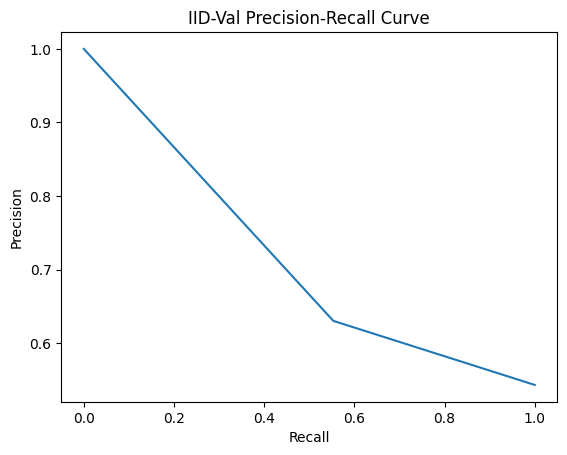

In [9]:
# Eval on iid val data
X_iid_val, Y_iid_val = data['iid_val']
X_iid_val_rand = model(X_iid_val)
evaluate(X_iid_val_rand, Y_iid_val, betas)

In [11]:
# Beta Model
mlp_ret = mlp_main(np.array(cluster_vectors), np.array(betas), X, model(X), labels)
print(f"MLP Metrics:\n\tTest Loss - {mlp_ret['test_loss']}\n\Agreement: Overall - {mlp_ret['overall_agreement']}, Subset - {mlp_ret['subset_agreement']}")

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1248 
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1077
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1002
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0939
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0872
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0832
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0783
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0752
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0722 
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0691
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


NameError: name 'percentile' is not defined

In [ ]:
# Draw new betas
M = 25_000
gen_clusters = np.random.randn(M, K)
gen_clusters = gen_clusters / np.linalg.norm(gen_clusters, axis=1, keepdims=True)
gen_betas = mlp_ret['mlp'].predict(gen_clusters)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy:  0.5375361656768692
Precision:  0.4784201954397394
Recall:  0.40088706925963835


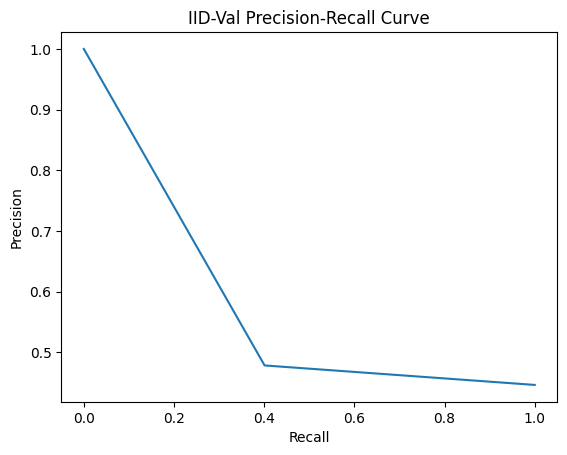

In [ ]:
# Eval on ood val data
X_ood_val, Y_ood_val = data['ood_val']
X_ood_val_rand = model(X_ood_val)
evaluate(X_ood_val_rand, Y_ood_val, gen_betas)

Accuracy:  0.481369150779896
Precision:  0.6197936568589989
Recall:  0.3845424371740161


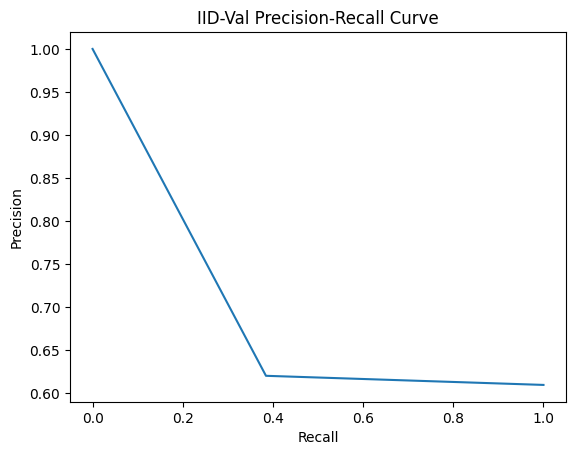

In [ ]:
# Eval on ood test data
X_ood_test, Y_ood_test = data['ood_test']
X_ood_test_rand = model(X_ood_test)
evaluate(X_ood_test_rand, Y_ood_test, gen_betas)